In [1]:
#================================
# 0. Imports and global settings
#================================
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
RANDOM_STATE = 42

pd.set_option("display.max_columns", 120)
pd.set_option("display.float_format", "{:,.4f}".format)


In [2]:
# ================================
# 1. Load Kaggle House Prices data
# ================================
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

train_df.head()


Train shape: (1460, 81)
Test shape : (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,"2,003.0000",RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,"1,976.0000",RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,"2,001.0000",RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,"1,998.0000",Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,"2,000.0000",RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


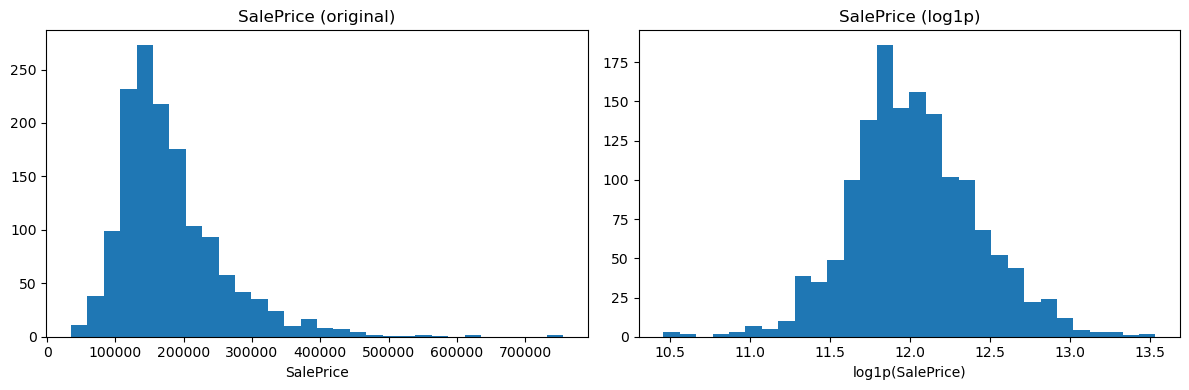

In [3]:
# ================================
# 2. Target and log-transform
# ================================
target = "SalePrice"
y = train_df[target]
X_full = train_df.drop(columns=[target])

y_log = np.log1p(y)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y, bins=30)
axes[0].set_title("SalePrice (original)")
axes[0].set_xlabel("SalePrice")

axes[1].hist(y_log, bins=30)
axes[1].set_title("SalePrice (log1p)")
axes[1].set_xlabel("log1p(SalePrice)")

plt.tight_layout()
plt.show()


In [4]:
# ================================
# 3. Domain-aware cleaning
# ================================

na_as_none_cols = [
    "Alley",
    "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "FireplaceQu",
    "GarageType", "GarageFinish", "GarageQual", "GarageCond",
    "PoolQC",
    "Fence",
    "MiscFeature",
]

numeric_to_categorical = ["MSSubClass"]

def basic_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # cast some numeric codes to string
    for col in numeric_to_categorical:
        if col in df.columns:
            df[col] = df[col].astype(str)

    # NA meaning "no feature"
    for col in na_as_none_cols:
        if col in df.columns:
            df[col] = df[col].fillna("None")

    return df

X_full_clean  = basic_cleaning(X_full)
test_df_clean = basic_cleaning(test_df)

numeric_features = X_full_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_full_clean.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 36
Categorical features: 44


In [5]:
# ================================
# 4. Train/validation split
# ================================
X_train, X_val, y_train_log, y_val_log = train_test_split(
    X_full_clean,
    y_log,
    test_size=0.2,
    random_state=RANDOM_STATE,
    shuffle=True,
)

X_train.shape, X_val.shape


((1168, 80), (292, 80))

In [6]:
# ================================
# 5. Preprocessing (fit once on train)
# ================================
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    sparse_threshold=0.0  # force dense output (easier indexing)
)

preprocessor.fit(X_train)

X_train_trans = preprocessor.transform(X_train)
X_val_trans   = preprocessor.transform(X_val)

print("Transformed shapes:", X_train_trans.shape, X_val_trans.shape)


Transformed shapes: (1168, 314) (292, 314)


In [7]:
# ================================
# 6. Helper: regression metrics
# ================================
def regression_metrics(y_true, y_pred, n_features=None):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if n_features is not None:
        n = len(y_true)
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    else:
        adj_r2 = None
    return mse, rmse, mae, r2, adj_r2

n_features_transformed = X_train_trans.shape[1]


In [8]:
# ================================
# 7. Price stratification (3 segments)
# ================================
q1 = y_train_log.quantile(0.33)
q2 = y_train_log.quantile(0.66)

def price_bucket(log_price):
    if log_price <= q1:
        return 0  # low
    if log_price <= q2:
        return 1  # mid
    return 2      # high

train_price_bucket = y_train_log.apply(price_bucket)

train_price_bucket.value_counts().sort_index()


SalePrice
0    394
1    385
2    389
Name: count, dtype: int64

In [9]:
# ================================
# 8. KMeans clustering within each price bucket
# ================================
cluster_labels_train = pd.Series(index=X_train.index, dtype=object)
kmeans_per_bucket = {}
k_per_bucket = {0: 3, 1: 3, 2: 3}  # can adjust per segment

for bucket in [0, 1, 2]:
    mask = (train_price_bucket == bucket)
    Xb = X_train_trans[mask.to_numpy()]

    k = k_per_bucket[bucket]
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cl = km.fit_predict(Xb)

    kmeans_per_bucket[bucket] = km
    cluster_labels_train.loc[mask] = [f"{bucket}_{c}" for c in cl]

cluster_labels_train.value_counts().sort_index()


0_0     35
0_1    216
0_2    143
1_0    125
1_1     97
1_2    163
2_0    193
2_1      4
2_2    192
Name: count, dtype: int64

In [10]:
# ================================
# 9. Assign validation samples to clusters
# ================================
cluster_labels_val = pd.Series(index=X_val.index, dtype=object)

for i in range(len(X_val)):
    pb = price_bucket(y_val_log.iloc[i])
    km = kmeans_per_bucket[pb]
    x = X_val_trans[i].reshape(1, -1)
    cl = km.predict(x)[0]
    cluster_labels_val.iloc[i] = f"{pb}_{cl}"

cluster_labels_val.value_counts().sort_index()


0_0     7
0_1    67
0_2    41
1_0    33
1_1    18
1_2    32
2_0    48
2_2    46
Name: count, dtype: int64

In [11]:
# ================================
# 10. Cluster-wise Ridge regression models
# ================================
cluster_ridge_models = {}
min_cluster_size = 30

for cl in sorted(cluster_labels_train.unique()):
    mask = (cluster_labels_train == cl)
    if mask.sum() < min_cluster_size:
        print(f"Cluster {cl}: size {mask.sum()} < {min_cluster_size} → skip.")
        continue

    X_cl = X_train_trans[mask.to_numpy()]
    y_cl = y_train_log[mask]

    model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    model.fit(X_cl, y_cl)

    cluster_ridge_models[cl] = model
    print(f"Trained Ridge model for cluster {cl} (n={mask.sum()})")

len(cluster_ridge_models)


Trained Ridge model for cluster 0_0 (n=35)
Trained Ridge model for cluster 0_1 (n=216)
Trained Ridge model for cluster 0_2 (n=143)
Trained Ridge model for cluster 1_0 (n=125)
Trained Ridge model for cluster 1_1 (n=97)
Trained Ridge model for cluster 1_2 (n=163)
Trained Ridge model for cluster 2_0 (n=193)
Cluster 2_1: size 4 < 30 → skip.
Trained Ridge model for cluster 2_2 (n=192)


8

In [12]:
# ================================
# 11. Global Ridge model (for ensemble)
# ================================
global_ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
global_ridge.fit(X_train_trans, y_train_log)


Ridge(random_state=42)

In [13]:
# ================================
# 12. Hybrid ensemble prediction on validation
#      final = w_cluster * cluster_pred + (1 - w_cluster) * global_pred
# ================================
w_cluster = 0.7  # paper-style weighting

y_val_pred_log_hybrid = np.zeros_like(y_val_log.values, dtype=float)

for i in range(len(X_val_trans)):
    cl = cluster_labels_val.iloc[i]
    x_i = X_val_trans[i].reshape(1, -1)

    if cl in cluster_ridge_models:
        pred_cl = cluster_ridge_models[cl].predict(x_i)[0]
    else:
        pred_cl = global_ridge.predict(x_i)[0]

    pred_gl = global_ridge.predict(x_i)[0]
    y_val_pred_log_hybrid[i] = w_cluster * pred_cl + (1 - w_cluster) * pred_gl

# Back to SalePrice scale
y_val_true = np.expm1(y_val_log.values)
y_val_pred_hybrid = np.expm1(y_val_pred_log_hybrid)


In [14]:
# ================================
# 13. FINAL HYBRID MODEL PERFORMANCE
# ================================
mse_h, rmse_h, mae_h, r2_h, adj_r2_h = regression_metrics(
    y_val_true, y_val_pred_hybrid, n_features_transformed
)

print("===================================")
print(" FINAL HYBRID MODEL PERFORMANCE ")
print("===================================")
print(f"MSE   : {mse_h:,.4f}")
print(f"RMSE  : {rmse_h:,.4f}")
print(f"MAE   : {mae_h:,.4f}")
print(f"R²    : {r2_h:,.4f}")
print(f"Adj R²: {adj_r2_h:,.4f}")


 FINAL HYBRID MODEL PERFORMANCE 
MSE   : 491,499,533.7560
RMSE  : 22,169.7888
MAE   : 14,724.5851
R²    : 0.9359
Adj R²: 1.8107


In [15]:
# ================================
# 14. Per-cluster validation metrics
# ================================
cluster_metrics = []

for cl in sorted(cluster_labels_val.unique()):
    mask = (cluster_labels_val == cl)
    n_val = mask.sum()
    if n_val == 0:
        continue

    y_true_cl = y_val_true[mask.to_numpy()]
    y_pred_cl = y_val_pred_hybrid[mask.to_numpy()]

    mse_c, rmse_c, mae_c, r2_c, _ = regression_metrics(y_true_cl, y_pred_cl)
    cluster_metrics.append({
        "cluster_final": cl,
        "n_val": n_val,
        "MSE": mse_c,
        "RMSE": rmse_c,
        "MAE": mae_c,
        "R2": r2_c
    })

cluster_metrics_df = pd.DataFrame(cluster_metrics).sort_values("RMSE")
cluster_metrics_df


,cluster_final,n_val,MSE,RMSE,MAE,R2
4,1_1,18,"88,902,303.6848","9,428.8018","8,139.2592",0.2153
0,0_0,7,"121,152,207.8185","11,006.9164","9,338.2790",0.4795
3,1_0,33,"140,194,443.2777","11,840.3734","9,767.1406",0.2491
1,0_1,67,"199,543,617.5747","14,125.9909","10,746.7324",0.5513
5,1_2,32,"273,527,428.3405","16,538.6646","11,934.5005",-0.3709
2,0_2,41,"280,088,813.2874","16,735.8541","13,230.5132",0.5907
6,2_0,48,"876,121,043.6082","29,599.3419","20,290.6042",0.9153
7,2_2,46,"1,321,378,017.0684","36,350.7636","24,935.9447",0.7871


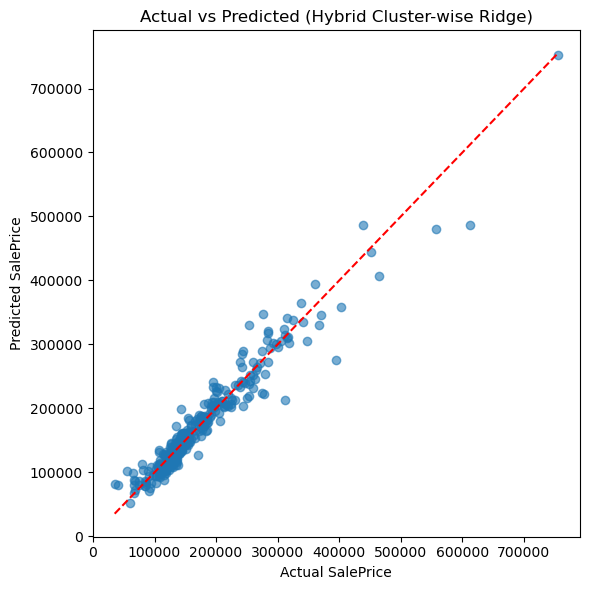

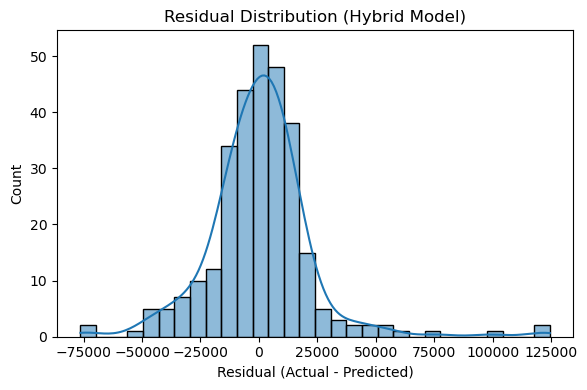

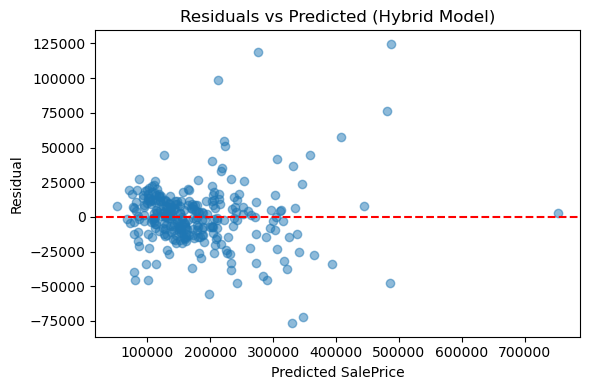

In [16]:
# ================================
# 15. Residual analysis (hybrid model)
# ================================
residuals = y_val_true - y_val_pred_hybrid

plt.figure(figsize=(6,6))
plt.scatter(y_val_true, y_val_pred_hybrid, alpha=0.6)
max_val = max(y_val_true.max(), y_val_pred_hybrid.max())
min_val = min(y_val_true.min(), y_val_pred_hybrid.min())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted (Hybrid Cluster-wise Ridge)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution (Hybrid Model)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_val_pred_hybrid, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted (Hybrid Model)")
plt.tight_layout()
plt.show()


In [17]:
# ================================
# 16. Coefficient "importance" example for one cluster
# ================================
def get_feature_names_from_preprocessor(preprocessor: ColumnTransformer):
    features = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == "remainder":
            continue
        if isinstance(transformer, Pipeline):
            last = transformer.steps[-1][1]
        else:
            last = transformer
        if hasattr(last, "get_feature_names_out"):
            feats = last.get_feature_names_out(cols)
        else:
            feats = cols
        features.extend(feats)
    return np.array(features)

feature_names_lr = get_feature_names_from_preprocessor(preprocessor)

coef_rows = []

for cl, model_cl in cluster_ridge_models.items():
    coefs = model_cl.coef_.ravel()
    df_c = pd.DataFrame({
        "cluster_final": cl,
        "feature": feature_names_lr,
        "coef": coefs,
        "abs_coef": np.abs(coefs)
    })
    coef_rows.append(df_c)

coef_df_all = pd.concat(coef_rows, ignore_index=True)
coef_df_all.head()


,cluster_final,feature,coef,abs_coef
0,0_0,Id,-0.0044,0.0044
1,0_0,LotFrontage,-0.0110,0.0110
2,0_0,LotArea,0.0026,0.0026
3,0_0,OverallQual,0.0222,0.0222
4,0_0,OverallCond,0.0363,0.0363


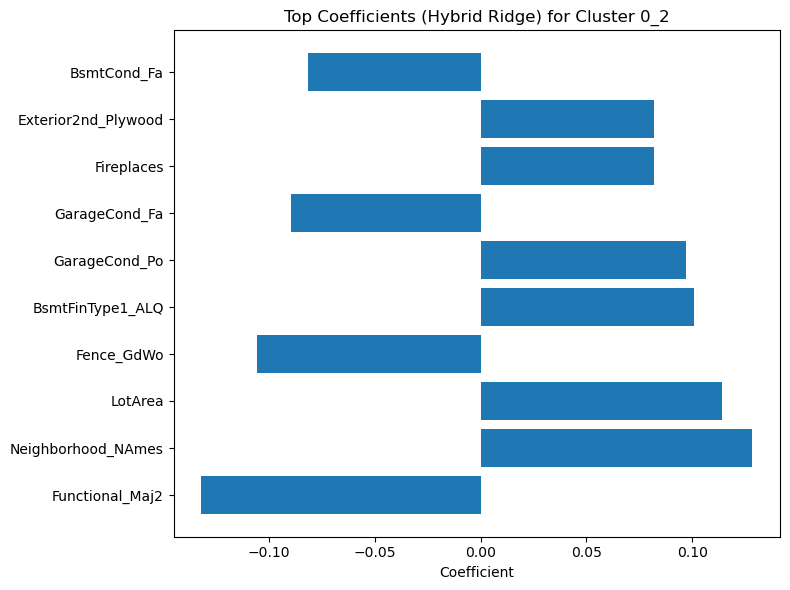

In [18]:
# Plot meaningful coefficients for one informative cluster
if not coef_df_all.empty:
    thresh = 1e-4
    max_abs_by_cluster = coef_df_all.groupby("cluster_final")["abs_coef"].max()
    valid_clusters = max_abs_by_cluster[max_abs_by_cluster > thresh]

    if not valid_clusters.empty:
        example_cluster = valid_clusters.idxmax()
        ex_df = (
            coef_df_all[
                (coef_df_all["cluster_final"] == example_cluster) &
                (coef_df_all["abs_coef"] > thresh)
            ]
            .sort_values("abs_coef", ascending=False)
            .head(10)
        )

        plt.figure(figsize=(8,6))
        plt.barh(ex_df["feature"], ex_df["coef"])
        plt.xlabel("Coefficient")
        plt.title(f"Top Coefficients (Hybrid Ridge) for Cluster {example_cluster}")
        plt.tight_layout()
        plt.show()
    else:
        print("No cluster has sufficiently large coefficients to plot.")
